In [2]:
# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2. Cài đặt unrar (bắt buộc để giải nén file .rar)
!apt-get install unrar

# 3. Tạo thư mục làm việc tạm thời trên Colab
import os
if not os.path.exists('/content/project'):
    os.makedirs('/content/project')
os.chdir('/content/project') # Chuyển thư mục làm việc về đây
print("Đã thiết lập môi trường thành công!")

Mounted at /content/drive
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
Đã thiết lập môi trường thành công!


In [1]:
# ==========================================
# LAYERS.PY
# ==========================================
%%writefile layers.py
import numpy as np

class Conv:
    def __init__(self, num_filters, filter_size=3):
        self.num_filters = num_filters
        self.filter_size = filter_size
        self.filters = np.random.randn(num_filters, filter_size, filter_size) / (filter_size * filter_size)

    def iterate_regions(self, image):
        h, w = image.shape
        for i in range(h - self.filter_size + 1):
            for j in range(w - self.filter_size + 1):
                im_region = image[i:(i + self.filter_size), j:(j + self.filter_size)]
                yield im_region, i, j

    def forward(self, input_data):
        self.last_input = input_data
        h, w = input_data.shape
        output_h = h - self.filter_size + 1
        output_w = w - self.filter_size + 1
        output = np.zeros((output_h, output_w, self.num_filters))
        for im_region, i, j in self.iterate_regions(input_data):
            output[i, j] = np.sum(im_region * self.filters, axis=(1, 2))
        return output

    def backprop(self, d_l_d_out, learn_rate):
        d_l_d_filters = np.zeros(self.filters.shape)
        for im_region, i, j in self.iterate_regions(self.last_input):
            for f in range(self.num_filters):
                d_l_d_filters[f] += d_l_d_out[i, j, f] * im_region
        self.filters -= learn_rate * d_l_d_filters
        return None

class ReLU:
    def forward(self, input_data):
        self.last_input = input_data
        return np.maximum(0, input_data)
    def backprop(self, d_l_d_out):
        return d_l_d_out * (self.last_input > 0)

class MaxPool:
    def __init__(self, pool_size=2, stride=2):
        self.pool_size = pool_size
        self.stride = stride

    def iterate_regions(self, image):
        h, w, num_filters = image.shape
        new_h = (h - self.pool_size) // self.stride + 1
        new_w = (w - self.pool_size) // self.stride + 1
        for i in range(new_h):
            for j in range(new_w):
                im_region = image[(i * self.stride):(i * self.stride + self.pool_size),
                                  (j * self.stride):(j * self.stride + self.pool_size)]
                yield im_region, i, j

    def forward(self, input_data):
        self.last_input = input_data
        h, w, num_filters = input_data.shape
        output_h = (h - self.pool_size) // self.stride + 1
        output_w = (w - self.pool_size) // self.stride + 1
        output = np.zeros((output_h, output_w, num_filters))
        for im_region, i, j in self.iterate_regions(input_data):
            output[i, j] = np.amax(im_region, axis=(0, 1))
        return output

    def backprop(self, d_l_d_out):
        d_l_d_input = np.zeros(self.last_input.shape)
        for im_region, i, j in self.iterate_regions(self.last_input):
            h_r, w_r, num_filters_r = im_region.shape
            amax = np.amax(im_region, axis=(0, 1))
            for r_i in range(h_r):
                for r_j in range(w_r):
                    for f_k in range(num_filters_r):
                        if im_region[r_i, r_j, f_k] == amax[f_k]:
                            input_i = i * self.stride + r_i
                            input_j = j * self.stride + r_j
                            d_l_d_input[input_i, input_j, f_k] += d_l_d_out[i, j, f_k]
        return d_l_d_input

class Flatten:
    def forward(self, input_data):
        self.last_input_shape = input_data.shape
        return input_data.flatten()
    def backprop(self, d_l_d_out):
        return d_l_d_out.reshape(self.last_input_shape)

class Dense:
    def __init__(self, input_len, output_len):
        self.weights = np.random.randn(input_len, output_len) / np.sqrt(input_len)
        self.biases = np.zeros(output_len)
    def forward(self, input_data):
        self.last_input = input_data
        return np.dot(input_data, self.weights) + self.biases
    def backprop(self, d_l_d_out, learn_rate):
        d_l_d_weights = np.outer(self.last_input, d_l_d_out)
        d_l_d_biases = d_l_d_out
        d_l_d_input = np.dot(d_l_d_out, self.weights.T)
        self.weights -= learn_rate * d_l_d_weights
        self.biases -= learn_rate * d_l_d_biases
        return d_l_d_input

class Dropout:
    def __init__(self, rate):
        self.rate = rate
        self.mask = None
    def forward(self, input_data, training=True):
        if training:
            self.mask = (np.random.rand(*input_data.shape) > self.rate) / (1.0 - self.rate)
            return input_data * self.mask
        return input_data
    def backprop(self, d_l_d_out):
        return d_l_d_out * self.mask

class Softmax:
    def forward(self, input_data):
        self.last_input_logits = input_data
        exp_shifted = np.exp(input_data - np.max(input_data, axis=-1, keepdims=True))
        self.last_output_probs = exp_shifted / np.sum(exp_shifted, axis=-1, keepdims=True)
        return self.last_output_probs
    def backprop(self, d_l_d_out_probs):
        p = self.last_output_probs
        return p * (d_l_d_out_probs - np.sum(d_l_d_out_probs * p, axis=-1, keepdims=True))

Writing layers.py


In [3]:
# ==========================================
# MODEL.PY
# ==========================================
%%writefile model.py
import numpy as np
import os
from layers import Conv, ReLU, MaxPool, Flatten, Dense, Dropout, Softmax

class CNNModel:
    def __init__(self, input_shape=(28, 28), num_classes=10,
                 conv_filters=8, conv_kernel_size=3,
                 pool_size=2, pool_stride=2,
                 dense1_nodes=128, dropout_rate=0.5):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.conv_filters = conv_filters
        self.conv_kernel_size = conv_kernel_size
        self.pool_size = pool_size
        self.pool_stride = pool_stride
        self.dense1_nodes = dense1_nodes
        self.dropout_rate = dropout_rate

        self.conv1 = Conv(num_filters=self.conv_filters, filter_size=self.conv_kernel_size)
        self.relu1 = ReLU()
        self.pool1 = MaxPool(pool_size=self.pool_size, stride=self.pool_stride)
        self.flatten_layer = Flatten()

        conv_out_h = self.input_shape[0] - self.conv_kernel_size + 1
        conv_out_w = self.input_shape[1] - self.conv_kernel_size + 1
        pool_out_h = (conv_out_h - self.pool_size) // self.pool_stride + 1
        pool_out_w = (conv_out_w - self.pool_size) // self.pool_stride + 1
        self.flattened_size = pool_out_h * pool_out_w * self.conv_filters

        self.dense1 = Dense(input_len=self.flattened_size, output_len=self.dense1_nodes)
        self.relu2 = ReLU()
        self.dropout1 = Dropout(rate=self.dropout_rate)
        self.dense2 = Dense(input_len=self.dense1_nodes, output_len=self.num_classes)
        self.softmax_activation = Softmax()

    def forward(self, image, training=True):
        img_processed = image - 0.5
        out = self.conv1.forward(img_processed)
        out = self.relu1.forward(out)
        out = self.pool1.forward(out)
        out = self.flatten_layer.forward(out)
        out = self.dense1.forward(out)
        out = self.relu2.forward(out)
        out = self.dropout1.forward(out, training=training)
        logits = self.dense2.forward(out)
        probs = self.softmax_activation.forward(logits)
        return probs, logits

    def save_model(self, path, idx_to_class_map):
        try:
            os.makedirs(os.path.dirname(path) or '.', exist_ok=True)
            params_to_save = {
                'img_h': self.input_shape[0], 'img_w': self.input_shape[1],
                'num_model_classes': self.num_classes, 'conv_filters_count': self.conv_filters,
                'conv_kernel_size': self.conv_kernel_size, 'pool_size': self.pool_size,
                'pool_stride': self.pool_stride, 'dense1_nodes': self.dense1_nodes,
                'dropout_rate': self.dropout_rate, 'conv1_filters': self.conv1.filters,
                'dense1_weights': self.dense1.weights, 'dense1_biases': self.dense1.biases,
                'dense2_weights': self.dense2.weights, 'dense2_biases': self.dense2.biases,
                'idx_to_class_map': np.array(list(idx_to_class_map.items()), dtype=object)
            }
            np.savez(path, **params_to_save)
            print(f"[SUCCESS] Saved model: {path}")
            return True
        except Exception as e:
            print(f"[ERROR] Save failed: {e}")
            return False

    @staticmethod
    def load_model(path):
        if not os.path.exists(path): return None, None
        try:
            data = np.load(path, allow_pickle=True)
            model = CNNModel(
                input_shape=(int(data['img_h']), int(data['img_w'])),
                num_classes=int(data['num_model_classes']),
                conv_filters=int(data['conv_filters_count']),
                conv_kernel_size=int(data['conv_kernel_size']),
                pool_size=int(data['pool_size']), pool_stride=int(data['pool_stride']),
                dense1_nodes=int(data['dense1_nodes']), dropout_rate=float(data['dropout_rate'])
            )
            model.conv1.filters = data['conv1_filters']
            model.dense1.weights = data['dense1_weights']
            model.dense1.biases = data['dense1_biases']
            model.dense2.weights = data['dense2_weights']
            model.dense2.biases = data['dense2_biases']
            idx_to_class_map = {int(item[0]): item[1] for item in data['idx_to_class_map']}
            return model, idx_to_class_map
        except Exception as e:
            print(f"[ERROR] Load failed: {e}")
            return None, None

Writing model.py


In [4]:
# ==========================================
# INPUT.PY
# ==========================================
%%writefile input.py
import numpy as np
import os
from PIL import Image as PILImage
import subprocess

def unzip_dataset(rar_path, unzip_dir):
    if not os.path.exists(unzip_dir): os.makedirs(unzip_dir)
    if not os.path.exists(rar_path): return False
    print(f"Unzipping {rar_path}...")
    try:
        subprocess.run(['unrar', 'x', '-o+', rar_path, unzip_dir + os.sep],
                       capture_output=True, check=True)
        return True
    except Exception as e:
        print(f"Unzip failed: {e}")
        return False

def load_custom_data(base_dir, target_size=(28, 28), max_images_per_class=None):
    images, labels = [], []
    if not os.path.exists(base_dir): return np.array([]), np.array([]), 0, {}, {}

    class_names = sorted([d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))])
    class_to_idx = {name: i for i, name in enumerate(class_names)}
    idx_to_class = {i: name for name, i in class_to_idx.items()}

    for class_name in class_names:
        class_dir = os.path.join(base_dir, class_name)
        files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if max_images_per_class: files = files[:max_images_per_class]

        for fname in files:
            try:
                img = PILImage.open(os.path.join(class_dir, fname)).convert('L')
                img = img.resize(target_size, PILImage.LANCZOS)
                img_arr = np.array(img, dtype=np.float32) / 255.0
                images.append(img_arr)
                labels.append(class_to_idx[class_name])
            except: continue

    return np.array(images, dtype=np.float32), np.array(labels, dtype=np.int32), len(class_names), idx_to_class, class_to_idx

def split_train_val(images, labels, val_split=0.2, random_seed=42):
    np.random.seed(random_seed)
    indices = np.random.permutation(len(images))
    split_idx = int(len(images) * (1 - val_split))
    train_idx, val_idx = indices[:split_idx], indices[split_idx:]
    return images[train_idx], labels[train_idx], images[val_idx], labels[val_idx]

Writing input.py


In [ ]:
%%writefile train.py
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from input import load_custom_data, unzip_dataset, split_train_val
from model import CNNModel

# ===== CẤU HÌNH =====
# Đường dẫn tới file RAR trên Google Drive
RAR_PATH = "/content/drive/MyDrive/Colab/dataset/CNN_letter_Dataset.rar"

# Thư mục để giải nén ra trên Colab
UNZIP_DIR = "/content/dataset"

# Nơi lưu model sau khi train
MODEL_SAVE_DIR = "/content/drive/MyDrive/Colab/model_output"
MODEL_NAME = "my_cnn_model.npz"
MODEL_SAVE_PATH = os.path.join(MODEL_SAVE_DIR, MODEL_NAME)

# Hyperparameters
EPOCHS = 15            # Số vòng lặp training
LEARNING_RATE = 0.005  # Tốc độ học
VAL_SPLIT = 0.2        # Dành 20% dữ liệu để kiểm tra (Validation)

def find_data_root(start_dir):
    """
    Hàm thông minh tự tìm thư mục chứa các class (0, 1, A, B...)
    để tránh lỗi sai đường dẫn sau khi giải nén.
    """
    # Kiểm tra ngay thư mục gốc
    subdirs = [d for d in os.listdir(start_dir) if os.path.isdir(os.path.join(start_dir, d))]
    # Nếu thấy folder tên là "0" hoặc "A" ngay đây thì đúng là nó
    if "0" in subdirs or "A" in subdirs:
        return start_dir

    # Nếu không, thử đi sâu vào 1 cấp (trường hợp giải nén ra folder cha)
    for d in subdirs:
        next_level = os.path.join(start_dir, d)
        sub_subdirs = [s for s in os.listdir(next_level) if os.path.isdir(os.path.join(next_level, s))]
        if "0" in sub_subdirs or "A" in sub_subdirs:
            return next_level

    return start_dir # Fallback

def plot_history(history, save_dir):
    """Vẽ biểu đồ và lưu lại"""
    if not os.path.exists(save_dir): os.makedirs(save_dir)

    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss', color='blue')
    plt.plot(history['val_loss'], label='Val Loss', color='red')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Acc', color='blue')
    plt.plot(history['val_acc'], label='Val Acc', color='red')
    plt.title('Training & Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    chart_path = os.path.join(save_dir, 'training_result_chart.png')
    plt.savefig(chart_path)
    print(f"\n[CHART] Đã lưu biểu đồ đánh giá tại: {chart_path}")
    # plt.show()

def train_step(model, img, lbl, lr):
    # Forward
    probs, _ = model.forward(img, training=True)

    # Tính Loss
    loss = -np.log(probs[lbl] + 1e-9)
    acc = 1 if np.argmax(probs) == lbl else 0

    # Backward
    grad_logits = probs.copy()
    grad_logits[lbl] -= 1

    # Truyền ngược (Backpropagation)
    d = model.dense2.backprop(grad_logits, lr)
    d = model.dropout1.backprop(d)
    d = model.relu2.backprop(d)
    d = model.dense1.backprop(d, lr)
    d = model.flatten_layer.backprop(d)
    d = model.pool1.backprop(d)
    d = model.relu1.backprop(d)
    model.conv1.backprop(d, lr)

    return loss, acc

def evaluate(model, images, labels):
    """Đánh giá model trên tập Validation"""
    loss_sum, correct = 0, 0
    for img, lbl in zip(images, labels):
        probs, _ = model.forward(img, training=False)
        loss_sum += -np.log(probs[lbl] + 1e-9)
        if np.argmax(probs) == lbl: correct += 1
    return loss_sum/len(images), (correct/len(images))*100

def main():
    print("=== BẮT ĐẦU QUÁ TRÌNH TRAINING ===")

    # 1. Giải nén Dataset
    if not unzip_dataset(RAR_PATH, UNZIP_DIR):
        print(f"[LỖI] Không thể giải nén file: {RAR_PATH}")
        print("Hãy kiểm tra kỹ đường dẫn file RAR trên Google Drive của bạn.")
        return

    # 2. Xác định thư mục chứa data
    print("[INFO] Đang tìm thư mục dữ liệu...")
    data_dir = find_data_root(UNZIP_DIR)
    print(f"[INFO] Đã tìm thấy dữ liệu tại: {data_dir}")

    # 3. Load toàn bộ dữ liệu
    print(f"[INFO] Đang load ảnh và nhãn từ {data_dir}...")
    # Lưu ý: dataset của bạn không chia train/test nên ta load hết 1 cục
    images, labels, num_classes, idx_to_class, _ = load_custom_data(data_dir)

    if len(images) == 0:
        print(f"[LỖI] Không tìm thấy ảnh nào! Hãy kiểm tra lại file nén.")
        return

    # 4. Chia Train / Validation tự động (80% train, 20% val)
    print(f"[INFO] Đang chia dữ liệu (Validation Split = {VAL_SPLIT})...")
    train_X, train_y, val_X, val_y = split_train_val(images, labels, val_split=VAL_SPLIT)

    print("-" * 50)
    print(f"Tổng số Class: {num_classes}")
    print(f"Dữ liệu Train: {len(train_X)} ảnh")
    print(f"Dữ liệu Valid: {len(val_X)} ảnh")
    print(f"Kích thước ảnh input: {train_X[0].shape}")
    print("-" * 50)

    # 5. Khởi tạo Model
    model = CNNModel(input_shape=train_X[0].shape, num_classes=num_classes)

    # Lưu lịch sử để vẽ biểu đồ
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    # 6. Training Loop
    for epoch in range(EPOCHS):
        # Xáo trộn dữ liệu mỗi epoch
        perm = np.random.permutation(len(train_X))
        train_X, train_y = train_X[perm], train_y[perm]

        epoch_loss, epoch_acc = 0, 0
        start_time = time.time()

        # Train từng ảnh (SGD)
        for i, (img, lbl) in enumerate(zip(train_X, train_y)):
            l, a = train_step(model, img, lbl, LEARNING_RATE)
            epoch_loss += l
            epoch_acc += a

            # In tiến độ mỗi 200 ảnh
            if i % 200 == 0:
                percent = (i / len(train_X)) * 100
                print(f"\r  Epoch {epoch+1} Running... {percent:.1f}%", end="")

        # Tổng kết Epoch
        train_avg_loss = epoch_loss / len(train_X)
        train_avg_acc = (epoch_acc / len(train_X)) * 100

        # Đánh giá trên tập Validation
        val_loss, val_acc = evaluate(model, val_X, val_y)

        # Lưu history
        history['train_loss'].append(train_avg_loss)
        history['train_acc'].append(train_avg_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"\rEpoch {epoch+1:02d}/{EPOCHS} | "
              f"Train Loss: {train_avg_loss:.4f} Acc: {train_avg_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f} Acc: {val_acc:.2f}% | "
              f"Time: {time.time()-start_time:.1f}s")

    # 7. Lưu Model và Biểu đồ
    print("\n[INFO] Đang lưu kết quả...")
    model.save_model(MODEL_SAVE_PATH, idx_to_class)
    plot_history(history, MODEL_SAVE_DIR)
    print("\n=== HOÀN TẤT ===")

if __name__ == '__main__':
    main()

Overwriting train.py


In [ ]:
!python train.py

=== BẮT ĐẦU QUÁ TRÌNH TRAINING ===
Unzipping /content/drive/MyDrive/Colab/dataset/CNN_letter_Dataset.rar...
[INFO] Đang tìm thư mục dữ liệu...
[INFO] Đã tìm thấy dữ liệu tại: /content/dataset/CNN letter Dataset
[INFO] Đang load ảnh và nhãn từ /content/dataset/CNN letter Dataset...
[INFO] Đang chia dữ liệu (Validation Split = 0.2)...
--------------------------------------------------
Tổng số Class: 31
Dữ liệu Train: 25152 ảnh
Dữ liệu Valid: 6288 ảnh
Kích thước ảnh input: (28, 28)
--------------------------------------------------
Epoch 01/15 | Train Loss: 0.9724 Acc: 70.94% | Val Loss: 0.2021 Acc: 94.77% | Time: 994.1s
Epoch 02/15 | Train Loss: 0.3251 Acc: 89.65% | Val Loss: 0.0951 Acc: 97.57% | Time: 998.0s
Epoch 03/15 | Train Loss: 0.2147 Acc: 93.05% | Val Loss: 0.0628 Acc: 98.22% | Time: 996.8s
Epoch 04/15 | Train Loss: 0.1692 Acc: 94.45% | Val Loss: 0.0406 Acc: 98.92% | Time: 993.5s
Epoch 05/15 | Train Loss: 0.1305 Acc: 95.73% | Val Loss: 0.0337 Acc: 99.03% | Time: 995.7s
Epoch 06/1

Hay chon mot file anh chu cai (A-Z, 0-9) tu may tinh cua ban:


Saving C.jpg to C.jpg


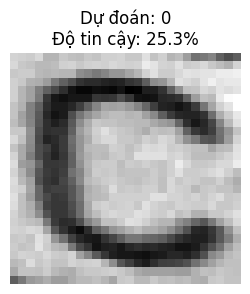

-> File 'C.jpg' được nhận diện là: 0


In [6]:
from google.colab import files
from PIL import Image as PILImage
import numpy as np
import matplotlib.pyplot as plt
from model import CNNModel
import io

# ===== CẤU HÌNH =====
MODEL_PATH = "/content/drive/MyDrive/Colab/model_output/my_cnn_model.npz"

def predict_uploaded_image():
    # 1. Load Model trước
    model, idx_to_class = CNNModel.load_model(MODEL_PATH)
    if model is None: return

    # 2. Cho user upload file
    print("Hay chon mot file anh chu cai (A-Z, 0-9) tu may tinh cua ban:")
    uploaded = files.upload()

    for fn in uploaded.keys():
        # 3. Xử lý ảnh upload
        image_data = uploaded[fn]
        img_pil = PILImage.open(io.BytesIO(image_data)).convert('L') # Chuyển sang đen trắng

        # Resize về đúng kích thước model đã học (28x28)
        img_resized = img_pil.resize((28, 28), PILImage.LANCZOS)
        img_array = np.array(img_resized, dtype=np.float32) / 255.0 # Normalize

        # 4. Dự đoán
        probs, _ = model.forward(img_array, training=False)
        pred_idx = np.argmax(probs)
        pred_label = idx_to_class[pred_idx]
        confidence = probs[pred_idx] * 100

        # 5. Hiển thị kết quả
        plt.figure(figsize=(3, 3))
        plt.imshow(img_array, cmap='gray')
        plt.title(f"Dự đoán: {pred_label}\nĐộ tin cậy: {confidence:.1f}%")
        plt.axis('off')
        plt.show()
        print(f"-> File '{fn}' được nhận diện là: {pred_label}")

# Chạy hàm test upload
predict_uploaded_image()